In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [3]:
model_outputs = pd.read_csv("data/final_model_output.csv")
clusters = pd.read_csv("data/cluster_centroids.csv")
clusters.head(7)

,team_Dives,team_Tanks,team_Damages,team_Enchanters,team_Picks,team_Pokes,team_Engages,team_Splitpushs,early_game,mid_game,late_game,no_damage_type
0,0.338721,0.368182,1.581481,0.048822,0.482997,0.311953,1.834848,0.032997,1.402862,2.294613,1.302525,0.0
1,1.358480,0.874204,1.022381,0.104187,0.367741,0.495852,0.726027,0.051129,1.117885,2.950994,0.931121,0.0
2,0.502921,0.822875,0.504993,0.177690,0.775391,1.440362,0.708121,0.067647,2.209158,1.601847,1.188996,0.0
3,0.319630,1.531121,1.774971,0.015849,0.260360,0.460459,0.630675,0.006934,0.881790,1.460129,2.658082,0.0
4,0.496651,0.704295,1.314224,1.070331,0.305162,0.538416,0.532506,0.038416,1.479905,1.261032,2.259062,0.0
5,0.242928,0.763643,1.072093,0.216828,0.398978,0.551743,0.716007,1.037781,0.995802,1.804891,2.199306,0.0
6,0.548780,1.295122,1.079268,0.413415,0.201220,0.451220,0.806098,0.204878,1.113415,1.926829,1.959756,1.0


In [4]:
#  Cloud9 vs Counter Logic Gaming LCS 2022 Summer finals Upper Bracket Round 1 Game 1

# model_outputs.query("league=='LCS' & date > '2022-01-01' & draft_diff > 0.20")
df = pd.DataFrame(model_outputs.iloc[33622]).transpose()
a = [(i,j) for i, j in (zip(df.columns, df.values[0]))]
# print(*a, sep='\n')

# C9 comp3 (front to back teamfight) - CLG comp 4 (enchanter)
# ('draft_agnostic_bot_lead_prob', 0.5942269097768489) ('post_draft_bot_lead_prob', 0.7372007974020272) 
# ('draft_agnostic_mid_lead_prob', 0.6505183895429077) ('post_draft_mid_lead_prob', 0.6804281799049113) 
# ('draft_agnostic_top_lead_prob', 0.607523785776135)  ('post_draft_top_lead_prob', 0.5761634507989283)
 
# C9:  Kennen, Trundle, Orianna, Kalista, Ashe
# CLG: Sejuani, Vi, Sylas, Sivir, Rennata

Model Coeff analysis

In [5]:
with open("models/post_draft/final_model.obj", "rb") as file:
    model = pickle.load(file)

b = [(i,j) for i,j in zip(model.params.keys(),model.params.values)]
c = sorted(b, key=lambda x: abs(x[1]), reverse=True)
print(*c, sep='\n')

('post_draft_mid_lead_prob:post_draft_top_lead_prob', 8.962665234239742)
('post_draft_mid_lead_prob:team_comp5_v_opp_comp5', 7.17073080886433)
('post_draft_bot_lead_prob:post_draft_top_lead_prob', 4.711162559240934)
('post_draft_bot_lead_prob:team_comp5_v_opp_comp5', -4.561070171865242)
('post_draft_top_lead_prob', -4.486723262084228)
('post_draft_mid_lead_prob:team_comp0_v_opp_comp0', 3.921034432554638)
('post_draft_bot_lead_prob:team_comp0_v_opp_comp0', -3.6721603294244347)
('post_draft_mid_lead_prob:team_comp4_v_opp_comp4', 3.1753709700534007)
('post_draft_bot_lead_prob:post_draft_mid_lead_prob', 2.9699983354098167)
('post_draft_mid_lead_prob', -2.924431069839413)
('post_draft_bot_lead_prob:team_comp1_v_opp_comp1', 2.2407210260827326)
('post_draft_top_lead_prob:team_comp5_v_opp_comp5', -1.8979003377162564)
('post_draft_mid_lead_prob:team_comp3_v_opp_comp3', 1.7534502867360477)
('post_draft_bot_lead_prob', -1.3728259637926787)
('team_comp4_v_opp_comp4', -1.322382227487666)
('post_dra

In [6]:
# Why do some teams do worse than others with the same strategy? 
# Eg early games are more dependent on skill?
# When we look at a one comp, can we see a correlation with skill (what would be nice is if you're a bad team ,you should not be drafting early game)

recent_LCS_games = model_outputs.query("league == 'LCS' & date > '2021-01-01'")

new = recent_LCS_games.iloc[:, 14:63].idxmax(axis=1)
comp = new.str.split("_v_").to_list()
comp = [int(x[0].replace("team_comp", "")) for x in comp]
recent_LCS_games['teamcomp'] = comp

<ipython-input-6-57f6bdd2915b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_LCS_games['teamcomp'] = comp


In [7]:
# 2 is early game
team2 = pd.Series(recent_LCS_games.query("teamcomp==2").groupby(by=["teamname"])["result"].mean(), name="team2")
allof = pd.Series(recent_LCS_games.groupby(by=["teamname"])["result"].mean(), name="all")
top = pd.Series(recent_LCS_games.query("teamcomp==2").groupby(by=["teamname"])["post_draft_top_lead_prob"].mean(), name="top")
mid = pd.Series(recent_LCS_games.query("teamcomp==2").groupby(by=["teamname"])["post_draft_mid_lead_prob"].mean(), name="mid")
bot = pd.Series(recent_LCS_games.query("teamcomp==2").groupby(by=["teamname"])["post_draft_bot_lead_prob"].mean(), name="bot")
df = pd.concat([allof, team2, top, mid, top], axis=1)
df['diff'] =  df['team2'] - df['all']
df.head(10).sort_values("diff")


,all,team2,top,mid,top,diff
teamname,,,,,,
Counter Logic Gaming,0.369565,0.250000,0.520098,0.533066,0.520098,-0.119565
Cloud9,0.618182,0.500000,0.557066,0.619866,0.557066,-0.118182
Immortals,0.336957,0.222222,0.490269,0.528120,0.490269,-0.114734
Golden Guardians,0.308511,0.285714,0.459451,0.417531,0.459451,-0.022796
Evil Geniuses,0.644860,0.647059,0.631440,0.541916,0.631440,0.002199
100 Thieves,0.650943,0.666667,0.521588,0.552986,0.521588,0.015723
Dignitas,0.397849,0.437500,0.453623,0.465620,0.453623,0.039651
Team Liquid,0.654545,0.714286,0.560433,0.589207,0.560433,0.059740
FlyQuest,0.406250,0.642857,0.485745,0.492070,0.485745,0.236607


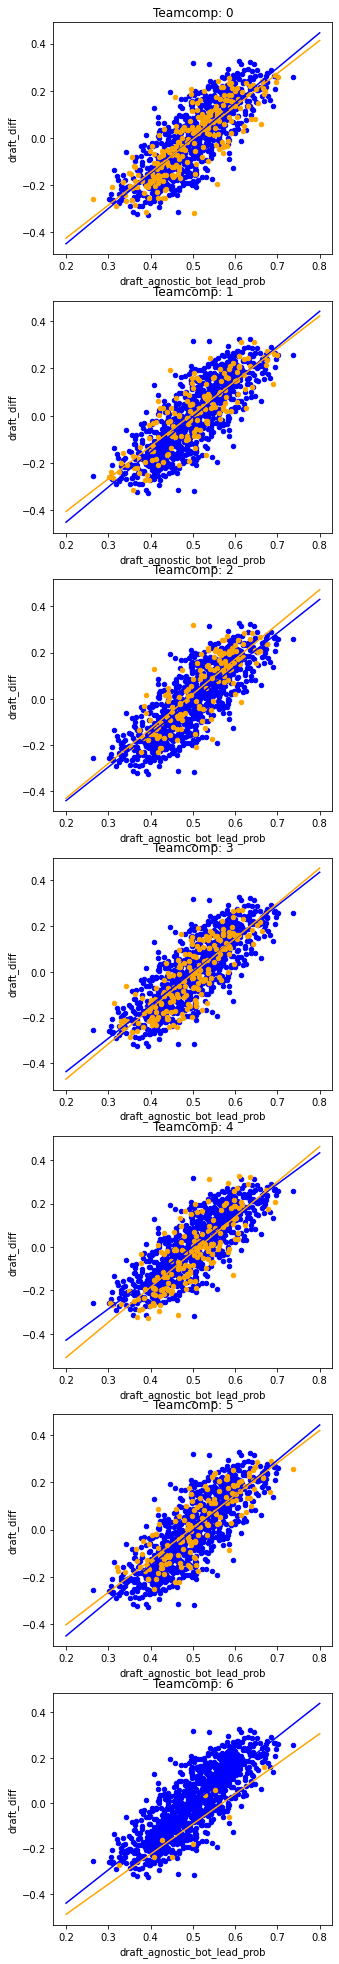

In [55]:
fig, ax = plt.subplots(7,1, figsize=(5, 35))

for tc in range(7):
    teamcomp2_not_2 = recent_LCS_games.query(f"teamcomp!={tc}")
    teamcomp2 = recent_LCS_games.query(f"teamcomp=={tc}")

    recent_LCS_games.columns
    a = np.polynomial.Polynomial.fit(teamcomp2_not_2["draft_agnostic_bot_lead_prob"], teamcomp2_not_2["draft_diff"], deg=1)
    b = np.polynomial.Polynomial.fit(teamcomp2["draft_agnostic_bot_lead_prob"], teamcomp2["draft_diff"], deg=1)
    x = np.linspace(0.2, 0.8, 10)
    ya = a(x)
    yb = b(x)
    ax[tc].plot(x, ya, color="blue")
    ax[tc].plot(x, yb, color = "orange")

    teamcomp2_not_2.plot(ax=ax[tc], kind="scatter", x="draft_agnostic_bot_lead_prob", y="draft_diff", color="blue")
    teamcomp2.plot(ax=ax[tc], kind="scatter", x="draft_agnostic_bot_lead_prob", y="draft_diff", color="orange")
    ax[tc].set_title(f"Teamcomp: {tc}")
    # recent_LCS_games.query("teamcomp==2").plot(ax=ax, kind="scatter", x="post_draft_ag_lead_prob", y="post_draft_win_prob", color='orange')


In [99]:
tc_games = recent_LCS_games.groupby("teamname", as_index=True)["teamcomp"].value_counts().to_frame("tc_count").reset_index()   #["teamcomp"].value_counts()
tc_games.pivot(index="teamname", columns="teamcomp", values="tc_count")

teamcomp,0,1,2,3,4,5,6
teamname,,,,,,,
100 Thieves,25.0,24.0,15.0,17.0,17.0,8.0,NaN
Cloud9,27.0,13.0,18.0,12.0,18.0,20.0,2.0
Counter Logic Gaming,25.0,11.0,8.0,15.0,16.0,16.0,1.0
Dignitas,16.0,15.0,16.0,20.0,11.0,14.0,1.0
Evil Geniuses,28.0,18.0,17.0,22.0,13.0,9.0,NaN
FlyQuest,16.0,11.0,14.0,25.0,17.0,13.0,NaN
Golden Guardians,23.0,14.0,7.0,17.0,16.0,16.0,1.0
Immortals,18.0,17.0,9.0,17.0,14.0,16.0,1.0
TSM,21.0,16.0,13.0,22.0,19.0,7.0,NaN
